In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import warnings

warnings.filterwarnings("ignore")
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


Data Preprocessing

In [7]:
def load_and_process_data(filepath):
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"Error: '{filepath}' not found. Please upload it to Colab.")
        return None, None, None, None

    # Check if data needs reshaping (Raw format vs Processed format)
    if df.shape[1] < 20:
        print("Detected raw data format. Processing...")
        df = df.rename(columns={0: 'prognosis'})
        df['record_id'] = df.index

        symptom_cols = [col for col in df.columns if col not in ['prognosis', 'record_id']]
        df_long = pd.melt(df, id_vars=['prognosis', 'record_id'], value_vars=symptom_cols, value_name='symptom')
        df_long = df_long.dropna(subset=['symptom'])
        df_long['present'] = 1

        training_df = df_long.pivot_table(index=['record_id', 'prognosis'],
                                          columns='symptom',
                                          values='present',
                                          fill_value=0).reset_index()
        training_df = training_df.drop(columns=['record_id'])

        # Standardize column names (remove spaces)
        new_cols = [str(col).strip().replace(' ', '_') for col in training_df.columns]
        training_df.columns = new_cols
    else:
        print("Detected processed data format.")
        training_df = df
        if 'prognosis' not in training_df.columns:
             training_df.rename(columns={training_df.columns[-1]: 'prognosis'}, inplace=True)

    # Removing duplicates
    initial_count = len(training_df)
    training_df = training_df.drop_duplicates()
    final_count = len(training_df)
    print(f"On removing duplicates: {initial_count} became {final_count} unique patterns.")

    all_symptoms = [col for col in training_df.columns if col != 'prognosis']
    X = training_df[all_symptoms].values
    y = training_df['prognosis']

    return X, y, all_symptoms, training_df

filename = 'dataset.csv'
X, y, all_symptoms, full_df = load_and_process_data(filename)

if X is not None:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(y)
    y_encoded = label_encoder.transform(y)
    y_one_hot = to_categorical(y_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.33, random_state=42)

    print(f"Data Processed Successfully.")
    print(f"Features: {len(all_symptoms)}")
    print(f"Classes (Diseases): {len(label_encoder.classes_)}")
    print(f"Training Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")

Detected raw data format. Processing...
On removing duplicates: 4920 became 304 unique patterns.
Data Processed Successfully.
Features: 131
Classes (Diseases): 41
Training Samples: 203, Test Samples: 101


Neural Network Model Training

In [11]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(len(all_symptoms),)),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(y_one_hot.shape[1], activation='softmax')
# ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# print("Starting Training...")
# history = model.fit(X_train, y_train,
#                     epochs=60,
#                     batch_size=16,
#                     validation_data=(X_test, y_test),
#                     verbose=1)
# print("Training Completed.")


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(all_symptoms),)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_one_hot.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Starting Training...")
history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)
print("Training Completed.")

Starting Training...
Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.0525 - loss: 3.7103 - val_accuracy: 0.1782 - val_loss: 3.6115
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1017 - loss: 3.6134 - val_accuracy: 0.2475 - val_loss: 3.5153
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1479 - loss: 3.5011 - val_accuracy: 0.3168 - val_loss: 3.4169
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2357 - loss: 3.3782 - val_accuracy: 0.3960 - val_loss: 3.3033
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2951 - loss: 3.3135 - val_accuracy: 0.4455 - val_loss: 3.1755
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3384 - loss: 3.1847 - val_accuracy: 0.5050 - val_loss: 3.0237
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4390 - loss: 3.0279 - val_accuracy: 0.5545 - val_loss: 2.8598
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4825 - loss: 2.8650 - val_accuracy: 0.584

Evaluation

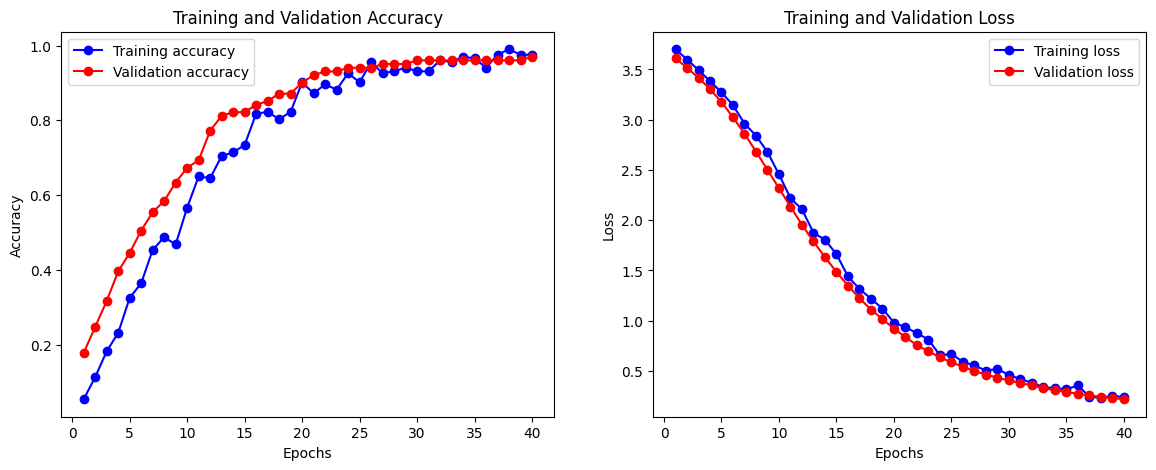


Test Accuracy: 97.03%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

--- Classification Report ---
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         2
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         3
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      0.25      0.40         4
                              Arthritis       1.00      1.00      1.00         2
                       Bronchial Asthma       1.00      1.00      1.00         4
                   Cervical spondylosis       1.00      1.00      1.00         2
                            Chicken pox       1.00      1.00      1.00         5
                    Chronic cholestasis       1.00      1.00      1.00         4
                

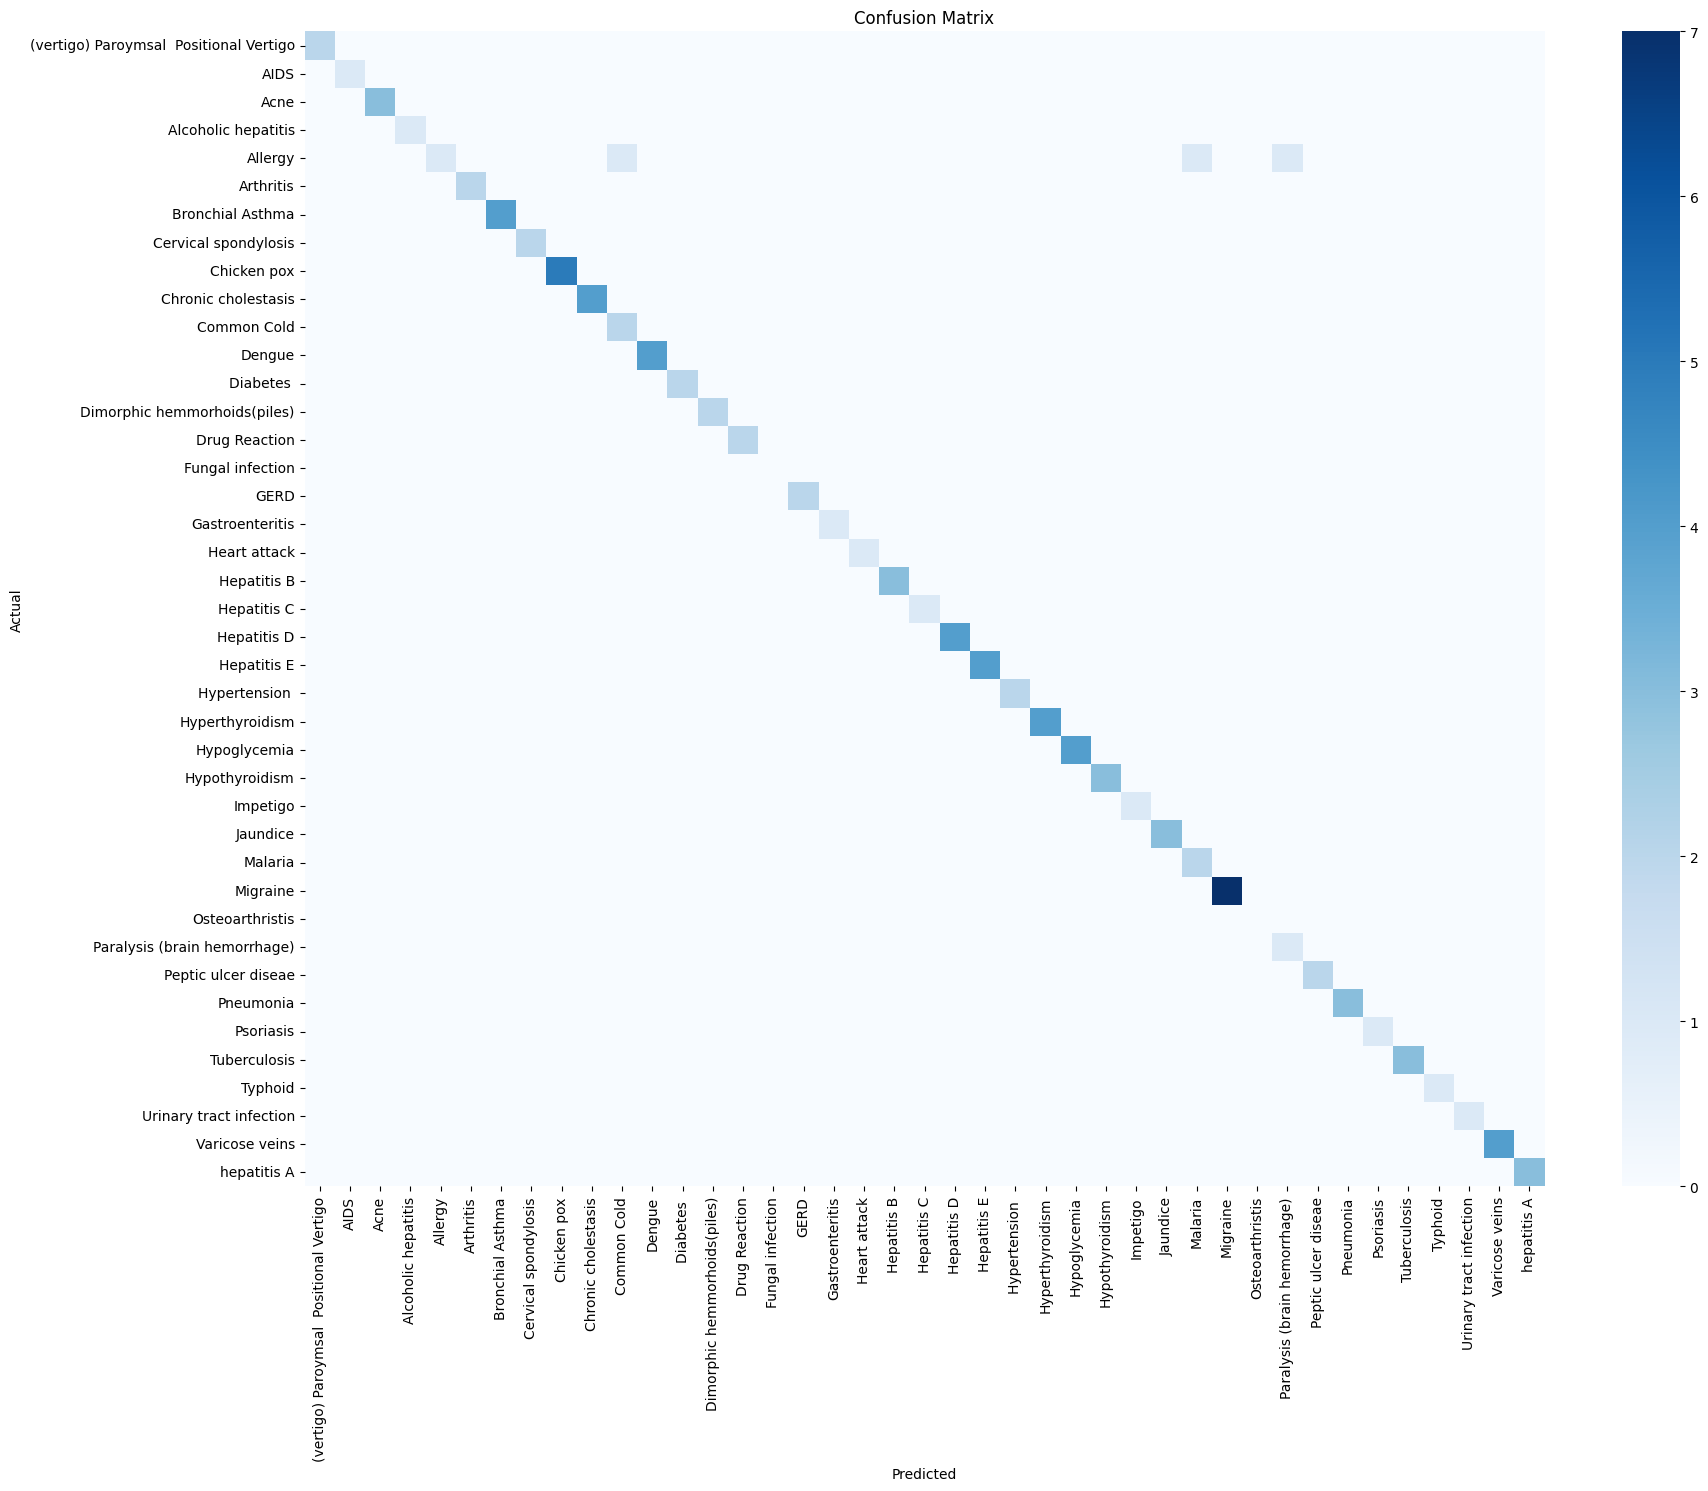

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def evaluate_model(model, X_test, y_test, label_encoder):
    # 1. Calculate Overall Accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

    # 2. Get Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Define all possible labels (0 to 40)
    all_labels = np.arange(len(label_encoder.classes_))

    # 3. Classification Report
    print("\n--- Classification Report ---")
    # We pass 'labels=all_labels' to force it to report on ALL diseases,
    # even those missing from the test set.
    print(classification_report(y_true, y_pred,
                                labels=all_labels,
                                target_names=label_encoder.classes_,
                                zero_division=0)) # Sets precision to 0 for missing classes instead of error

    # 4. Confusion Matrix Heatmap
    # We also pass 'labels=all_labels' here to ensure the matrix is 41x41
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)

    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=False, cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.show()

plot_training_history(history)
evaluate_model(model, X_test, y_test, label_encoder)

GUI

In [13]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

class ProfessionalHealthBot:
    def __init__(self, model, label_encoder, all_symptoms):
        self.model = model
        self.label_encoder = label_encoder
        self.all_symptoms = all_symptoms
        self.description_list = {}
        self.severityDictionary = {}
        self.precautionDictionary = {}

        self.load_csv_data()

        self.display_gui()

    def load_csv_data(self):
        def load_dict(path, target_dict, is_list=False, is_int=False):
            try:
                with open(path, 'r') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        if len(row) < 2: continue
                        key = row[0].strip()
                        if is_list:
                            target_dict[key] = [x.strip() for x in row[1:] if x.strip()]
                        elif is_int:
                            try: target_dict[key] = int(row[1])
                            except: pass
                        else:
                            target_dict[key] = row[1].strip()
            except FileNotFoundError:
                pass

        load_dict('symptom_Description.csv', self.description_list)
        load_dict('symptom_severity.csv', self.severityDictionary, is_int=True)
        load_dict('symptom_precaution.csv', self.precautionDictionary, is_list=True)

    def predict_disease(self, b):
        self.out.clear_output()
        with self.out:
            raw_input = self.symptom_input.value.split(',')
            user_symptoms = [s.strip().replace(' ', '_') for s in raw_input if s.strip()]

            try:
                days = int(self.days_input.value)
            except ValueError:
                print("System Error: Please enter a valid number for days.")
                return

            input_vec = np.zeros(len(self.all_symptoms))
            matched_symptoms = []

            for sym in user_symptoms:
                matches = [s for s in self.all_symptoms if sym.lower() in s.lower()]
                if matches:
                    best_match = min(matches, key=len)
                    idx = self.all_symptoms.index(best_match)
                    input_vec[idx] = 1
                    matched_symptoms.append(best_match)

            if not matched_symptoms:
                print(f"No known symptoms detected. Please check spelling.")
                print(f"Try standard terms like: 'itching', 'skin_rash', 'joint_pain', 'vomiting'.")
                return

            print(f"Symptoms Detected: {', '.join(matched_symptoms)}")

            pred_probs = self.model.predict(input_vec.reshape(1, -1), verbose=0)[0]

            top_3_indices = np.argsort(pred_probs)[-3:][::-1]
            top_3_probs = pred_probs[top_3_indices]

            primary_idx = top_3_indices[0]
            primary_disease = self.label_encoder.inverse_transform([primary_idx])[0]
            confidence = top_3_probs[0] * 100

            print("-" * 50)
            print(f"Primary Diagnosis: {primary_disease}")
            print(f"Confidence Score:  {confidence:.2f}%")
            print("-" * 50)

            if confidence < 50:
                print("Low Confidence Warning: The symptoms provided are ambiguous.")
                print("Consider the alternative possibilities below:\n")

            if len(top_3_indices) > 1:
                print("Alternative Possibilities:")
                for i in range(1, len(top_3_indices)):
                    alt_idx = top_3_indices[i]
                    alt_disease = self.label_encoder.inverse_transform([alt_idx])[0]
                    alt_prob = top_3_probs[i] * 100
                    if alt_prob > 1.0:
                        print(f"   - {alt_disease} ({alt_prob:.2f}%)")

            print("\n" + "=" * 50)

            desc = self.description_list.get(primary_disease, "No description available.")
            print(f"Overview: {desc}\n")

            severity_score = 0
            for sym in matched_symptoms:
                clean_sym = sym.replace('_', ' ')
                severity_score += self.severityDictionary.get(clean_sym, 1)

            avg_severity = (severity_score * days) / (len(matched_symptoms) + 1)

            print("AI ADVICE:")
            if avg_severity > 13:
                print("High Severity Indicators. Consult a doctor immediately.")
            else:
                print("Condition appears manageable. Monitor symptoms.")

            precautions = self.precautionDictionary.get(primary_disease, [])
            if precautions:
                print("\nRecommended Precautions:")
                for i, p in enumerate(precautions):
                    print(f"   {i+1}. {p}")

            print("\n" + "*" * 50)
            print("DISCLAIMER: This is an AI prototype for educational purposes only.")
            print("It is NOT a substitute for professional medical advice.")
            print("*" * 50)

    def display_gui(self):
        style = {'description_width': 'initial'}
        self.symptom_input = widgets.Text(
            description="Symptoms (comma-separated):",
            placeholder="e.g. itching, skin_rash",
            style=style, layout=widgets.Layout(width='80%')
        )
        self.days_input = widgets.Text(
            description="Duration (days):",
            placeholder="e.g. 3",
            style=style, layout=widgets.Layout(width='30%')
        )
        self.btn = widgets.Button(
            description="Analyze Symptoms",
            button_style='danger',
            icon='user-md',
            layout=widgets.Layout(width='30%')
        )
        self.out = widgets.Output()

        self.btn.on_click(self.predict_disease)

        display(widgets.VBox([
            widgets.HTML("<h2>Professional Health Assistant AI</h2>"),
            widgets.HTML("<i>Enter multiple symptoms separated by commas for better accuracy.</i>"),
            self.symptom_input,
            self.days_input,
            self.btn,
            self.out
        ]))

app = ProfessionalHealthBot(model, label_encoder, all_symptoms)